In [34]:
from astroquery.mast import Observations
from astropy.io import fits
from astropy.table import Table
import math

In [23]:
tic = 270577175
obsTable = Observations.query_criteria(provenance_name='TESS-SPOC',target_name=tic)
data = Observations.get_product_list(obsTable)

In [24]:
#download_lc = Observations.download_products(data)

In [25]:
cd hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_tp/


[Errno 2] No such file or directory: 'hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_tp/'
/Users/azib/Documents/PhD/Exocomets/automated_exocomet_hunt/mastDownload/HLSP/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_tp


In [26]:
ls

hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits
hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_tp.fits


In [56]:
hdulist = fits.open('hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits')
hdulist[1].data

FITS_rec([(1468.28332026, 0.00154374, 11559, 5440095. , 64.05369, 11814.139, 6.1606474,       nan,       nan, 8, nan, nan, nan, nan, 1661.22948378, 1.20871273e-05, 619.01059233, 5.3862706e-05,         nan,         nan),
          (1468.3041536 , 0.00154376, 11560, 5441052.5, 64.05927, 11819.849, 6.1587396, 5507612. , 64.86285 , 0, nan, nan, nan, nan, 1661.22873677, 1.20848999e-05, 619.01157383, 5.3873198e-05,  0.01709123,  0.04153716),
          (1468.32498695, 0.00154379, 11561, 5440696.5, 64.05729, 11821.125, 6.1617174, 5507246.5, 64.86083 , 0, nan, nan, nan, nan, 1661.22803465, 1.20856666e-05, 619.01201823, 5.3865642e-05,  0.01612137,  0.04193074),
          ...,
          (1489.99151787, 0.00141688, 12601, 5443009. , 64.06723, 11567.07 , 6.126722 , 5509699.5, 64.870895, 0, nan, nan, nan, nan, 1661.21266742, 1.21172870e-05, 618.93175386, 5.3750755e-05,  0.0006166 , -0.07778622),
          (1490.01235089, 0.00141656, 12602, 5442564. , 64.0643 , 11550.364, 6.121054 , 5508939. , 64.867

In [57]:
def import_lightcurve(file_path, drop_bad_points=False,
                      ok_flags=[5]):
    """Returns (N by 2) table, columns are (time, flux).

    Flags deemed to be OK are:
    5 - reaction wheel zero crossing, matters for short cadence
    """

    try:
        hdulist = fits.open(file_path)
    except FileNotFoundError:
        print("Import failed: file not found")
        return

    scidata = hdulist[1].data
    table = Table(scidata)['TIME','PDCSAP_FLUX','QUALITY']

    if drop_bad_points:
        bad_points = []
        q_ind = get_quality_indices(table['QUALITY'])
        for j,q in enumerate(q_ind):
            if j+1 not in ok_flags:
                bad_points += q.tolist()

        # bad_points = [i for i in range(len(table)) if table[i][2]>0]
        table.remove_rows(bad_points)

    # Delete rows containing NaN values.
    nan_rows = [ i for i in range(len(table)) if
            math.isnan(table[i][1]) or math.isnan(table[i][0]) ]

    table.remove_rows(nan_rows)

    # Smooth data by deleting overly 'spikey' points.
    spikes = [ i for i in range(1,len(table)-1) if \
            abs(table[i][1] - 0.5*(table[i-1][1]+table[i+1][1])) \
            > 3*abs(table[i+1][1] - table[i-1][1])]

    for i in spikes:
        table[i][1] = 0.5*(table[i-1][1] + table[i+1][1])

    return table


In [58]:
table = import_lightcurve('hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits')
len(table['TIME'])

971

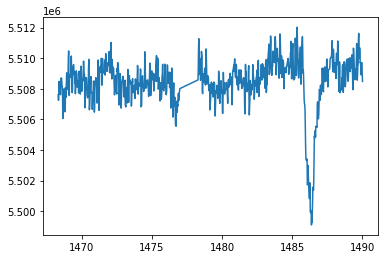

In [61]:
import matplotlib.pyplot as plt
plt.plot(table['TIME'],table['PDCSAP_FLUX'])

---

### Testing glob things

In [26]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
#[print(f"target found") for i in glob.glob('tess/2_min_cadence_targets/*.pkl') if i.endswith('.pkl')]

In [15]:
def lightcurves(path):
    data = pd.read_pickle(path)
    return data[3]

In [16]:
lightcurves('tess/2_min_cadence_targets/tesslc_100479167.pkl')

9.838000300000001

In [19]:
test = []
for i in glob.glob('tess/2_min_cadence_targets/*.pkl'):
    test.append(lightcurves(i))

In [86]:
values, base = np.histogram(test, bins=20)

18494

In [34]:
cumulative = np.cumsum(values) / len(test)


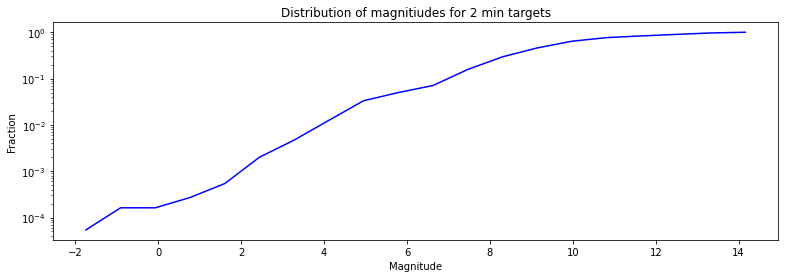

In [39]:
plt.figure(figsize=(13,4))
plt.plot(base[:-1], cumulative, c='blue')
plt.yscale('log')
plt.title('Distribution of magnitiudes for 2 min targets')
plt.xlabel('Magnitude')
plt.ylabel('Fraction')
plt.show()

Saturated stars ~ 6.8 Mag [Sullivan et al 2015](https://arxiv.org/pdf/1506.03845.pdf), [Feinstein et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PASP..131i4502F/abstract)

In [50]:
lim = 6.8
non_saturated = [i for i in test if i < lim] # less than because magnitudes work the other way

In [85]:
len(non_saturated)/len(test) * 100

5.309830215204931

---

In [63]:
from astropy.io import fits
import matplotlib.pyplot as plt

In [82]:
with fits.open('tess2018206045859-s0001-0000000024265755-0120-s_lc.fits','readonly') as hdulist:
    time = hdulist[1].data['TIME']
    flux = hdulist[1].data['SAP_FLUX']

In [84]:
len(time)

20076

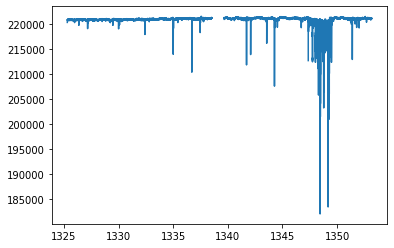

In [71]:
plt.plot(time,flux)

---

In [72]:
from astroquery.mast import Catalogs

In [74]:
catalog_data = Catalogs.query_criteria(catalog="Tic",Tmag = [1,7])

In [80]:
catalog_data

ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
str11,str8,int64,str12,str10,str16,str19,str19,str19,str8,int64,str8,str10,float64,float64,str10,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,int64,float64,str9,str9,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str8,str8,str13,float64,float64,float64,float64,float64,float64,int64,int64,str10
376084514,20190415,1131,4306-01424-1,817-000683,00140595+7323274,--,--,537903048479998208,60153712,--,STAR,tmgaia2,3.52489359226261,73.3909314934906,tmgaia2,-4.07105,0.0635699,5.7968,0.0657116,gaia2,1.47124,0.0423128,gaia2,120.227367253248,10.7155577722082,54.3183549086176,60.7166850371102,10.039,0.03,8.25,0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.996,0.244,3.141,0.208,2.713,0.272,DCD-333-111-000-0-0,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.022,0.001519,5.8287,0.0143,rered,gaia2,3512.0,122.0,nan,nan,nan,nan,116.415,nan,nan,nan,nan,nan,GIANT,nan,nan,667.298,19.0035,0.170118,0.03454015,--,nan,--,--,nan,0.0428576,0.0262227,panstarrs,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,18.472,19.535,bj2018,nan,nan,dered,8.57949,0.010372,5.84248,0.004559,1,--,hipvmag,tycho2b,--,1.22945819269299,1.01912363138507,3.5248322707909,73.3909564519442,0.0381246148096928,0.0347853785295864,0,0,3308491
407119572,20190415,1756,4302-00744-1,808-001347,00221435+7130291,--,J002214.39+713029.7,537086867256144640,59970723,--,STAR,tmgaia2,5.55978925789258,71.5081676952461,tmgaia2,16.8759,0.0417112,4.71762,0.0379624,gaia2,2.96632,0.0244517,gaia2,120.594988247658,8.7690292159781,52.0949920955724,59.0802978590373,8.897,0.304,7.61,0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.892,0.037,4.324,0.206,4.118,0.24,ECD-133-111-000-0-0,nan,3.995,0.281,3.757,0.187,3.957,0.015,3.874,0.024,7.0271,0.00028,6.18269,0.0061,rered,gaia2,4381.0,122.0,nan,nan,nan,nan,28.9127,nan,nan,nan,nan,nan,GIANT,nan,nan,333.893,2.747,0.18786,0.0327812,--,nan,--,--,nan,0.0494115,0.0161509,panstarrs,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.725,2.769,bj2018,nan,nan,dered,7.87489,0.001315,6.16624,0.001939,1,--,hipvmag,apassdr9,--,0.796969463412237,0.588737326104316,5.56001834717428,71.5081880073589,0.0218352158812109,0.0194123129126684,0,0,5161946
468349172,20190415,2332,0596-00064-1,499-000698,00295080+0941520,--,J002950.82+094151.9,2750813273326404864,38616633,--,STAR,tmgaia2,7.46170359333474,9.69777310071747,tmgaia2,17.1555,0.144411,-20.6023,0.0789919,gaia2,3.82031,0.0839688,gaia2,114.109083051565,-52.8037079630647,10.6873298906283,5.94836817134992,9.021,0.0,7.88,0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6.019,0.044,5.43